# CNV Diversity
## How many CNV events occur in the chemostat?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

rep_colors = {'wt':"black", 'ltr':"#6699cc", 'ars': "#e26d5c", 'all':"#DEBD52", "lauer": "grey"}

label_dict = {'wt': 'Wild type architecture', 'ltr': 'LTRs removed', 'ars': 'ARS removed', 'all': 'LTR and ARS removed', 'lauer': 'Lauer'}

## CNV events as function of evolutionary parameters

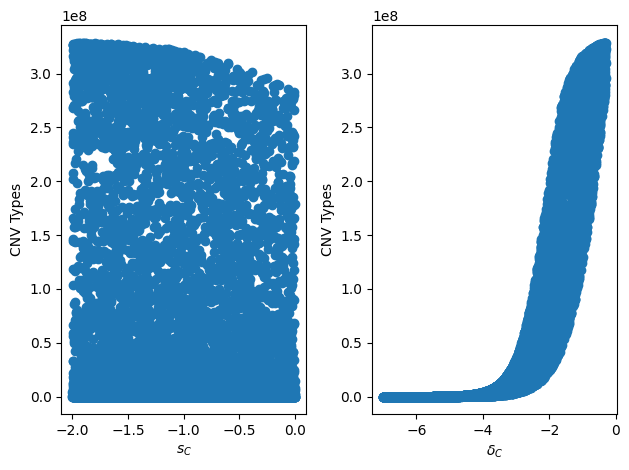

In [2]:
# Pre-simulated data - 10k simulations
# Each simulation's output is the comulative number of CNV events
div_df = pd.read_csv('presimulated_data/WF_presimulated_data_10000_diversity.csv', header=None)
div_df.columns = ['CNVs']

# Simulated parameters
div_theta = pd.read_csv('presimulated_data/WF_presimulated_theta_10000_diversity.csv', header=None).iloc[:,:-1]
div_theta.columns = ['$log(s_C)$', '$log(δ_C)$']

# Plotting CNV events as a function of model parameters
fig, ax = plt.subplots(1,2, tight_layout=True)
N = float(3.3e8)
for i in range(len(div_theta.columns)):
    c = div_theta.columns[i]
    ax[i].scatter(div_theta[c],div_df['CNVs'].astype(float))
    ax[i].set_xlabel(f'${c[5:-2]}$')
    ax[i].set_ylabel('CNV Types')

# CNV Events exclusively by $\delta_C$
## Assuming no selection, the total number of CNV events can be approximated by a geometric sum:
### $N_{cnv} \approx \delta_C + \delta_C*(1-\delta_C-\delta_B) + \delta_C*{(1-\delta_C-\delta_B)^2}+...=$
### $ = { {\delta_C*{[1-(1-\delta_C-\delta_B)^{T}]}} \over {\delta_C+\delta_B} }$

Text(0, 0.5, 'CNV Types')

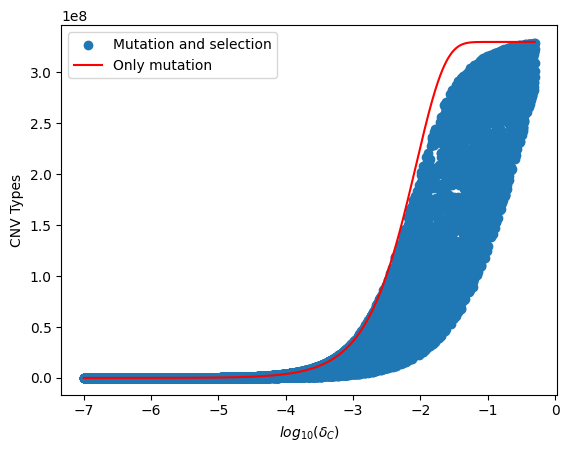

In [3]:
plt.scatter(div_theta['$log(δ_C)$'],div_df['CNVs'].astype(float), label='Mutation and selection')

x = 10**div_theta['$log(δ_C)$'].sort_values()
y = x*((1-x-(10**-5))**116-1)/(-x-(10**-5))
plt.plot(np.log10(x),y*N, color='red', label = 'Only mutation')
plt.legend()
# plt.ylim(0,5e6)
plt.xlabel('$log_{10}(δ_C)$')
plt.ylabel('CNV Types')
# plt.xlim(-6,-3)

# CNV events distribution estimation
## Groups of alleles with the same frequency

/home/jupyter-nadavbennun/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jupyter-nadavbennun/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jupyter-nadavbennun/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jupyter-nadavbennun/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be

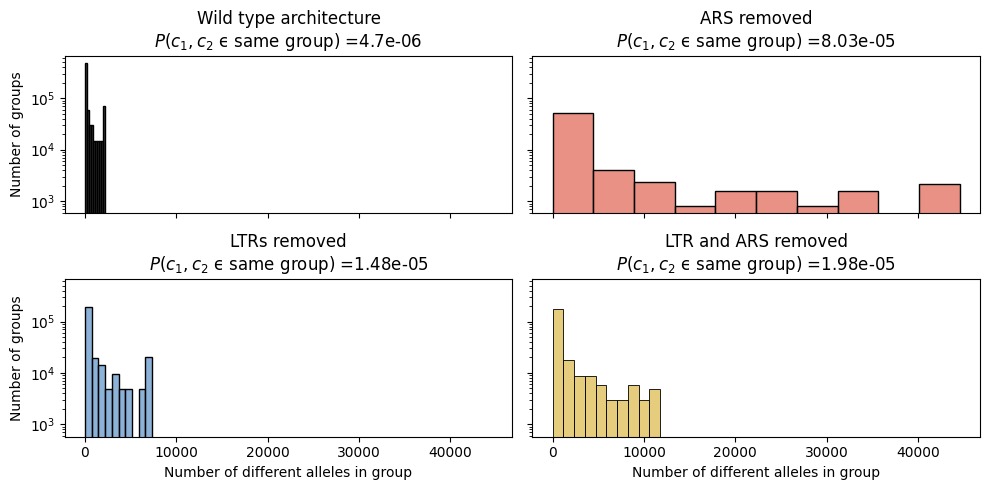

In [4]:
from diversity import simpleWF
from seaborn import histplot as hst

def calc_c1_c2_prob(ax, params, max_possible, color, plot = True, max_gen = 116):
    s_cnv,m_cnv,p_0 = 10**params
    N=3.3e8
    generation = pd.read_csv(f'Chuong_116_gens.txt', delimiter = ', ', engine='python').columns.astype('int')
    Q,P = simpleWF(N, generation, s_cnv, m_cnv, p_0, max_possible)
    Q,P = Q[:max_gen+2], P[:max_gen+2]
    Q,P = Q[Q>1], P[Q>1] # Only count generations with at least one whole new CNV cell
    X = P.sum()
    tot_P = 0
    dist_list = []
    for t in range(len(Q)):
        tot_P += (P[t]**2/Q[t])/X**2
        dist_list = dist_list + [P[t]/Q[t] for i in range(int(Q[t]))]
    
    if plot:
        hst(dist_list, stat='count', bins=10, ax=ax, color=color)
        ax.set_xlabel('Number of different alleles in group')
        ax.set_ylabel('Number of groups')
        ax.set_yscale('log')
    return tot_P, Q, P

fig,ax = plt.subplots(2,2, figsize=(10,5), tight_layout=True, sharex=True, sharey=True)
collective_maps = pd.read_csv('maps/collective_maps.csv', index_col=0)   

p, Q, P = calc_c1_c2_prob(ax[0,0],collective_maps.loc['wt',:][2:], np.inf, color=rep_colors['wt']) # WT collective MAP
ax[0,0].set_title(f'{label_dict["wt"]}\n$P(c_1,c_2$ ϵ same group) ={round(p,7)}')
p, Q, P = calc_c1_c2_prob(ax[1,0],collective_maps.loc['ltr',:][2:], np.inf, color=rep_colors['ltr']) # LTR collective MAP
ax[1,0].set_title(f'{label_dict["ltr"]}\n$P(c_1,c_2$ ϵ same group) ={round(p,7)}')
p, Q, P = calc_c1_c2_prob(ax[0,1],collective_maps.loc['ars',:][2:], np.inf, color=rep_colors['ars']) # ARS collective MAP
ax[0,1].set_title(f'{label_dict["ars"]}\n$P(c_1,c_2$ ϵ same group) ={round(p,7)}')
p, Q, P = calc_c1_c2_prob(ax[1,1],collective_maps.loc['all',:][2:], np.inf, color=rep_colors['all']) # ALL collective MAP
ax[1,1].set_title(f'{label_dict["all"]}\n$P(c_1,c_2$ ϵ same group) ={round(p,7)}')
plt.show()

## Diversity Plots Over Time

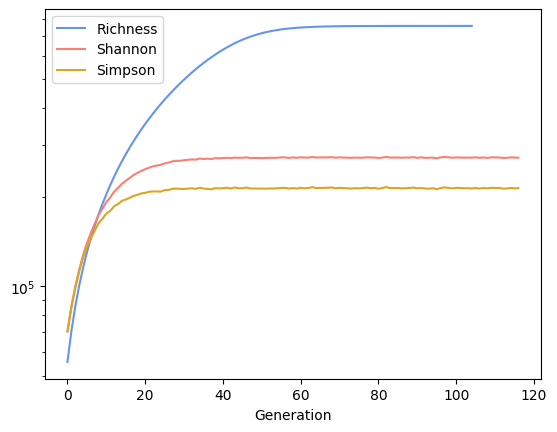

In [5]:
# Total number distinct CNVs = richness
params = collective_maps.loc['wt',:][2:]
fig,ax = plt.subplots()
p, Q, P = calc_c1_c2_prob(ax, params, np.inf, color='k', plot=False) # WT collective MAP
ax.plot(Q.cumsum(), label='Richness', color='cornflowerblue') # Richness = total CNVs
ax.set_yscale('log')
ax.set_xlabel('Generation')

# Other diversity indices
plot_shannon, plot_simpson = [], []
for j in range(117):
    tot_p, Q, P = calc_c1_c2_prob(ax, params, np.inf, color='k', plot=False, max_gen=j)
    shannon, simpson = 0,0
    for i in range(len(Q)):
        p = max(1e-12,(P[i]/Q[i])/P.sum()) # Proportion of each CNV population
        shannon -= Q[i]*p*np.log(p) # Q[i] populations with the same proportion
        simpson += Q[i]*p**2 # Q[i] populations with the same proportion
    plot_shannon.append(np.exp(shannon))
    plot_simpson.append(1/simpson)

ax.plot(plot_shannon, label='Shannon', color='salmon')
ax.plot(plot_simpson, label='Simpson', color='goldenrod')
ax.legend()

# Shannon Diversity

## HDR (parameters)

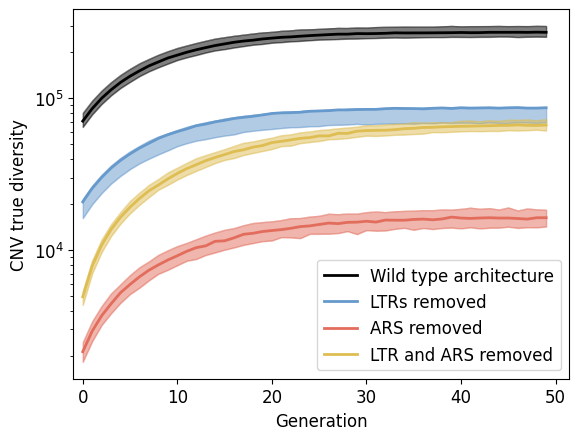

In [13]:
import matplotlib as mpl
label_size = 12
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
mpl.rcParams['font.size'] = label_size

# Plot Shannon diversity for all lines
# Collective MAP and 50% HDR
def plot_shannon_diversity(ax, line, params, legend, linewidth):
    plot_shannon = []
    for j in range(50):
        tot_p, Q, P = calc_c1_c2_prob(ax, params, np.inf, color='k', plot=False, max_gen=j) # Get generational quantities
        shannon = 0
        for i in range(len(Q)):
            p = max(1e-12,(P[i]/Q[i])/P.sum()) # Proportion of each CNV population
            shannon -= Q[i]*p*np.log(p) # Q[i] populations with the same proportion
        plot_shannon.append(np.exp(shannon))
        
    if legend:
        ax.plot(plot_shannon, color=rep_colors[line], label=label_dict[line], linewidth=linewidth)
        ax.legend(fontsize=12)
    else:
        ax.plot(plot_shannon, color=rep_colors[line], linewidth=linewidth)
    
    return plot_shannon

fig,ax = plt.subplots()
collective_maps = pd.read_csv('maps/collective_maps.csv', index_col=0)   
collective_samples = pd.read_csv('maps/collective_posterior_samples.csv', index_col=0)
for line in ['wt','ltr','ars','all']:
    params = collective_maps.loc[line,:][2:]
    y = plot_shannon_diversity(ax,line, params, legend=True, linewidth=2)
    params_25 = collective_samples[collective_samples['line']==line].iloc[:,1:].astype('float').quantile(0.25)[-3:]
    y_25 = plot_shannon_diversity(ax,line, params_25, legend=False, linewidth=0.1)
    params_75 = collective_samples[collective_samples['line']==line].iloc[:,1:].astype('float').quantile(0.75)[-3:]
    y_75 = plot_shannon_diversity(ax,line, params_75, legend=False, linewidth=0.1)
    ax.fill_between([i for i in range(len(y))],y_25,y_75, color= rep_colors[line], alpha=0.5)

ax.set_yscale('log')
ax.set_ylabel('CNV true diversity')
ax.set_xlabel('Generation')
ax.set_xlim(-1)
plt.show()

## HDR (Diversities)

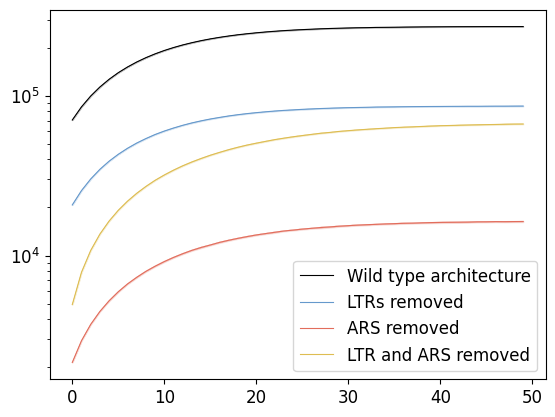

In [14]:
diversity_df = pd.read_csv('maps/collective_diversities.csv', index_col=0)

fig,ax = plt.subplots()
ax.set_yscale('log')
ax.set_xticks([10*i for i in range(6)])
ax.set_xticklabels([10*i for i in range(6)])
for line in ['wt', 'ltr', 'ars', 'all']:
    d = diversity_df[diversity_df['line']==line].iloc[:,1:]
    x = np.array(d.columns.tolist())
    d_25, d_75 = d.quantile(0.25), d.quantile(0.75)
    ax.plot(x, d_25, linewidth=0.1, color=rep_colors[line])
    ax.plot(x, d_75, linewidth=0.1, color=rep_colors[line])
    ax.fill_between(x,d_25,d_75, color= rep_colors[line], alpha=0.2)
    ax.plot(x, d.mean(), color= rep_colors[line], linewidth=0.8, label=label_dict[line])
ax.legend()